In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Titanic data + random columns

In [2]:
titanic_url = ('https://raw.githubusercontent.com/amueller/'
               'scipy-2017-sklearn/091d371/notebooks/datasets/titanic3.csv')
titanic = pd.read_csv(titanic_url)

In [3]:
rng = np.random.RandomState(42)
titanic['random_cat'] = rng.randint(3, size=titanic.shape[0])
titanic['random_num'] = rng.randn(titanic.shape[0])

In [4]:
titanic.describe()

,pclass,survived,age,sibsp,parch,fare,body,random_cat,random_num
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000,1309.000000,1309.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917,0.977082,0.071915
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922,0.820845,0.990013
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000,0.000000,-2.940389
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000,0.000000,-0.601368
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000,1.000000,0.066991
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000,2.000000,0.709004
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000,2.000000,3.193108


In [5]:
titanic.head(10)

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON",2,1.271555
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON",0,0.721672
5,1,1,"Anderson, Mr. Harry",male,48.0000,0,0,19952,26.5500,E12,S,3,NaN,"New York, NY",0,-1.129052
6,1,1,"Andrews, Miss. Kornelia Theodosia",female,63.0000,1,0,13502,77.9583,D7,S,10,NaN,"Hudson, NY",2,-0.524520
7,1,0,"Andrews, Mr. Thomas Jr",male,39.0000,0,0,112050,0.0000,A36,S,NaN,NaN,"Belfast, NI",1,0.489375
8,1,1,"Appleton, Mrs. Edward Dale (Charlotte Lamson)",female,53.0000,2,0,11769,51.4792,C101,S,D,NaN,"Bayside, Queens, NY",2,-1.222128
9,1,0,"Artagaveytia, Mr. Ramon",male,71.0000,0,0,PC 17609,49.5042,NaN,C,NaN,22.0,"Montevideo, Uruguay",2,0.712998


In [6]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

data = titanic[categorical_columns + numerical_columns]
labels = titanic['survived']

In [7]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(
    data, labels, stratify=labels, random_state=42)

## Building a Feature Engineering Pipeline

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # no scaler needed for random forests
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(n_estimators=100,
                                          min_samples_leaf=1,
                                          random_state=42))
])

In [9]:
%%time
rf.fit(X_train, y_train)

CPU times: user 128 ms, sys: 4 ms, total: 132 ms
Wall time: 128 ms


Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeli...                       min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=42,
                                        verbose=0, warm_start=False))])

In [10]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


## Tree-based Feature Importances

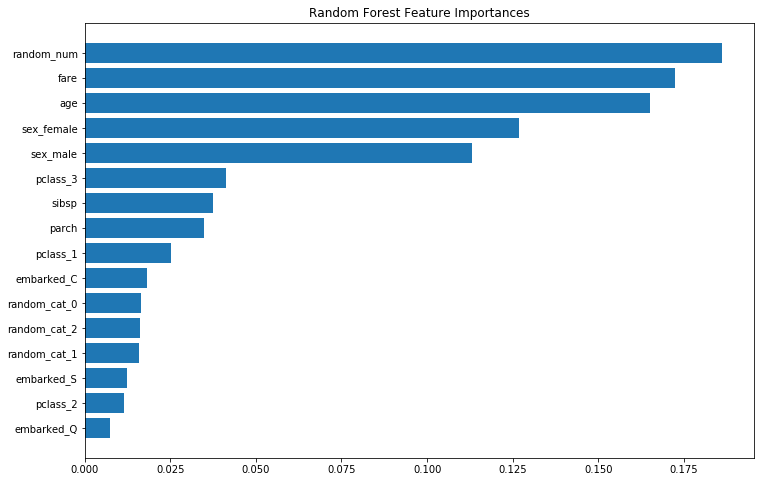

In [11]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = []
for col, cats in zip(categorical_columns, ohe.categories_):
    for cat in cats:
        feature_names.append("{}_{}".format(col, cat))
feature_names = np.array(feature_names + numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
_, ax = plt.subplots(figsize=(12, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances");

## Permutation-based Feature Importances (training set)

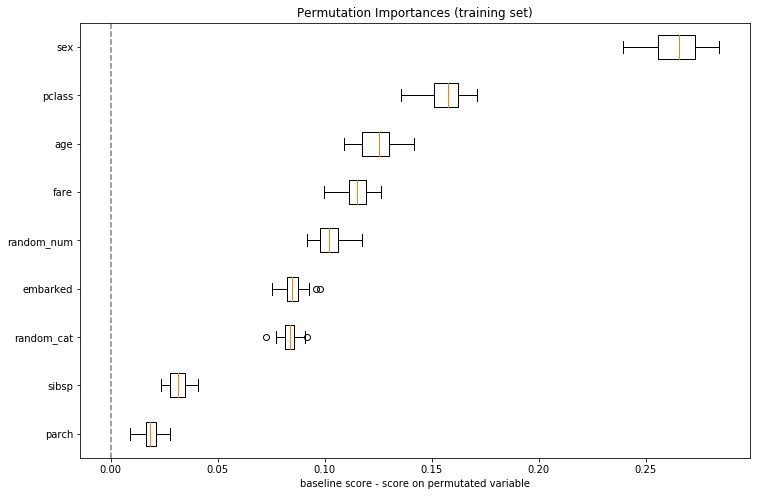

In [12]:
permute_importance = permutation_importance(rf, X_train, y_train, n_rounds=30,
                                            random_state=42)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.vlines(0, 0, X_test.shape[1] + 1, linestyles='dashed', alpha=0.5)
ax.set_xlabel("baseline score - score on permutated variable")
ax.set_title("Permutation Importances (training set)");

## Permutation-based Feature Importances (test set)

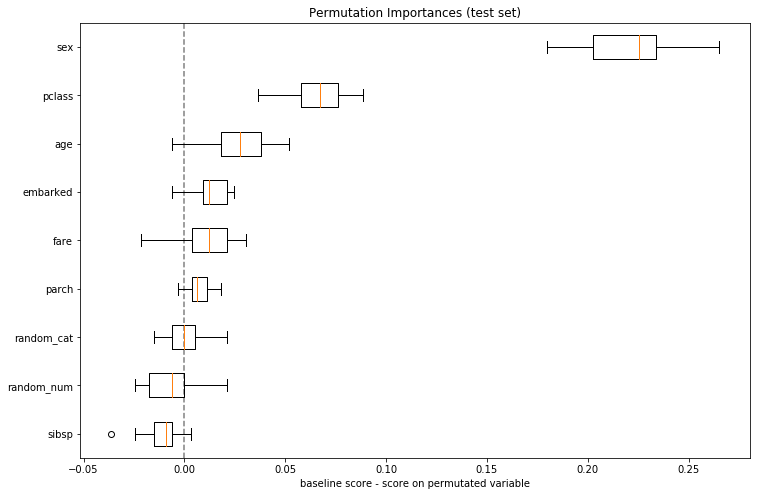

In [13]:
permute_importance = permutation_importance(rf, X_test, y_test, n_rounds=30,
                                            random_state=42)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.vlines(0, 0, X_test.shape[1] + 1, linestyles='dashed', alpha=0.5)
ax.set_xlabel("baseline score - score on permutated variable")
ax.set_title("Permutation Importances (test set)");

## Same Analysis With a Non-Overfitting Classifier

In [14]:
rf.named_steps['classifier'].set_params(min_samples_leaf=8)
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.833
RF test accuracy: 0.851


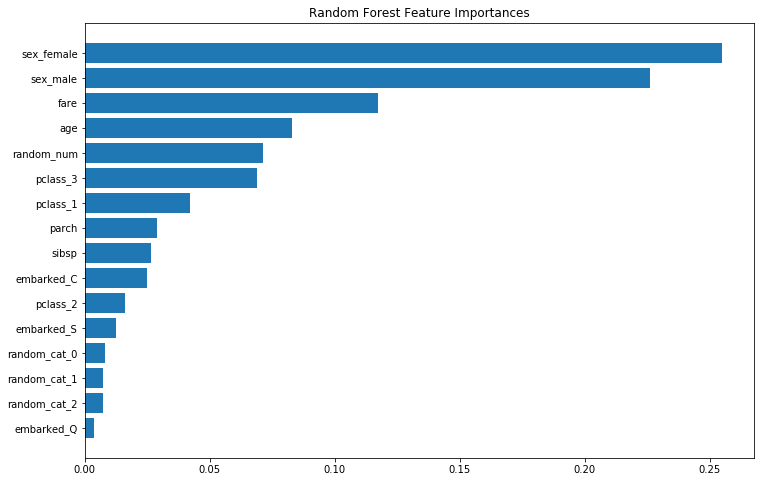

In [15]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = []
for col, cats in zip(categorical_columns, ohe.categories_):
    for cat in cats:
        feature_names.append("{}_{}".format(col, cat))
feature_names = np.array(feature_names + numerical_columns)

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
_, ax = plt.subplots(figsize=(12, 8))
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances");

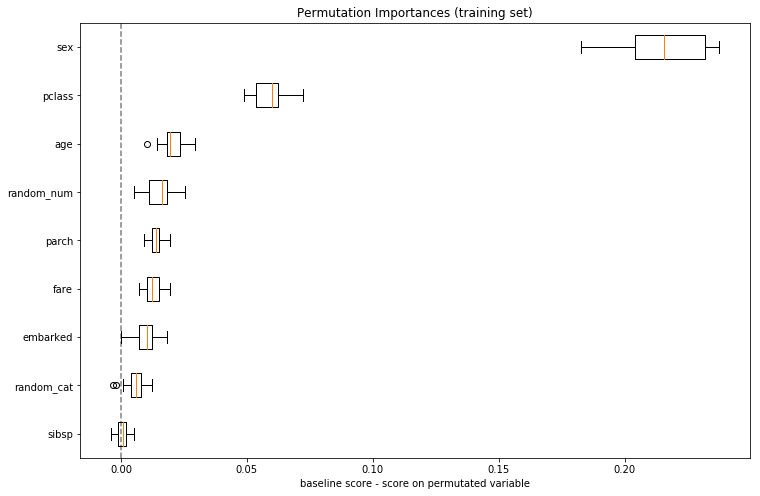

In [16]:
permute_importance = permutation_importance(rf, X_train, y_train, n_rounds=30,
                                            random_state=42)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.vlines(0, 0, X_test.shape[1] + 1, linestyles='dashed', alpha=0.5)
ax.set_xlabel("baseline score - score on permutated variable")
ax.set_title("Permutation Importances (training set)");

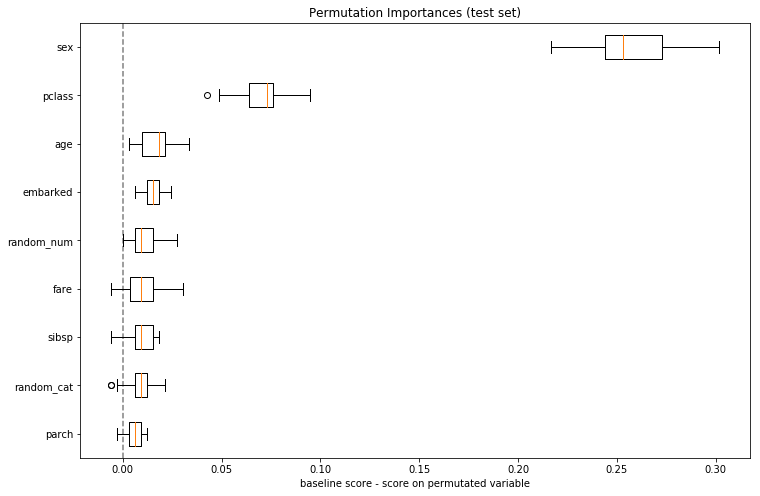

In [17]:
permute_importance = permutation_importance(rf, X_test, y_test, n_rounds=30,
                                            random_state=0)
permute_importance_mean = np.mean(permute_importance, axis=-1)
sorted_idx = permute_importance_mean.argsort()

_, ax = plt.subplots(figsize=(12, 8))
ax.boxplot(permute_importance[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.vlines(0, 0, X_test.shape[1] + 1, linestyles='dashed', alpha=0.5)
ax.set_xlabel("baseline score - score on permutated variable")
ax.set_title("Permutation Importances (test set)");